# 01 — EDA del dataset (manzana / naranja / platano)



In [1]:
from pathlib import Path

# =========================
# 0) Estructura del proyecto (sin bash)
# =========================
base = Path("Proyecto")

folders = [
    base / "Notebooks",
    base / "App",
    base / "src",
    base / "reports",
    base / "models",
    base / "mlruns",
    base / "continuous_data" / "images",
]
for f in folders:
    f.mkdir(parents=True, exist_ok=True)

# placeholders (para Git)
for p in [base/"src"/".gitkeep", base/"reports"/".gitkeep", base/"models"/".gitkeep"]:
    p.write_text("", encoding="utf-8")

print(" Estructura creada en:", base.resolve())

 Estructura creada en: C:\Users\ASUS\practica6\Proyecto


In [2]:
from pathlib import Path

# =========================
# 0.1) .gitignore recomendado
# =========================
gitignore = """
# Python
__pycache__/
*.pyc
.ipynb_checkpoints/

# OS
.DS_Store
Thumbs.db

# MLflow (tracking local)
Proyecto/mlruns/

# Artefactos pesados
Proyecto/models/
Proyecto/continuous_data/images/

# Datos (si luego copias datasets aquí)
data/
*.zip
"""

Path("Proyecto/.gitignore").write_text(gitignore.strip() + "\n", encoding="utf-8")
print(" Proyecto/.gitignore creado/actualizado")

 Proyecto/.gitignore creado/actualizado


In [3]:
# =========================
# 1) Imports + verificación de librerías
# =========================
import importlib
import sys
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def check(pkg):
    try:
        mod = importlib.import_module(pkg)
        ver = getattr(mod, "__version__", "ok")
        return True, ver
    except Exception as e:
        return False, str(e)

needed = ["mlflow", "tensorflow", "numpy", "pandas", "matplotlib", "PIL"]
status = {p: check(p) for p in needed}
pd.DataFrame(
    [{"pkg":k, "ok":v[0], "version_or_error":v[1]} for k,v in status.items()]
)

,pkg,ok,version_or_error
0,mlflow,True,3.7.0
1,tensorflow,True,2.20.0
2,numpy,True,2.1.3
3,pandas,True,2.2.3
4,matplotlib,True,3.10.0
5,PIL,True,11.1.0


In [4]:
from pathlib import Path

# =========================
# 2) Encontrar dataset_fruits + validar clases
# =========================
CANDIDATES = [
    Path("dataset_fruits"),
    Path("practica6/dataset_fruits"),
    Path("/mnt/data/practica6/dataset_fruits"),
]

DATA_DIR = next((c for c in CANDIDATES if c.exists()), None)
print("DATA_DIR =", DATA_DIR)
assert DATA_DIR is not None, " No encuentro dataset_fruits. Revisa la ruta."

# Ignorar carpetas ocultas (.ipynb_checkpoints, etc.)
classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir() and not p.name.startswith(".")])
print("Clases encontradas:", classes)

expected = sorted(["manzana", "naranja", "platano"])
assert classes == expected, f" Tus clases no coinciden. Esperado {expected}, pero encontré {classes}"

# Extensiones válidas
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

DATA_DIR = dataset_fruits
Clases encontradas: ['manzana', 'naranja', 'platano']


,clase,n_imagenes
0,manzana,40
1,naranja,33
2,platano,31


 TOTAL imágenes: 104


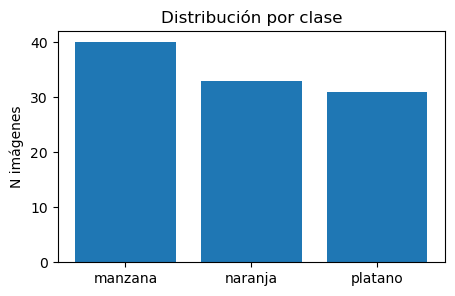

In [5]:
# =========================
# 3) Conteo por clase + desbalance
# =========================
rows = []
for cls in classes:
    files = [p for p in (DATA_DIR/cls).rglob("*") if p.suffix.lower() in IMG_EXTS]
    rows.append({"clase": cls, "n_imagenes": len(files)})

df_counts = pd.DataFrame(rows).sort_values("clase")
display(df_counts)

total = int(df_counts["n_imagenes"].sum())
print(" TOTAL imágenes:", total)
assert total > 0, " El dataset está vacío o no tiene extensiones de imagen válidas."

plt.figure(figsize=(5,3))
plt.bar(df_counts["clase"], df_counts["n_imagenes"])
plt.title("Distribución por clase")
plt.ylabel("N imágenes")
plt.show()

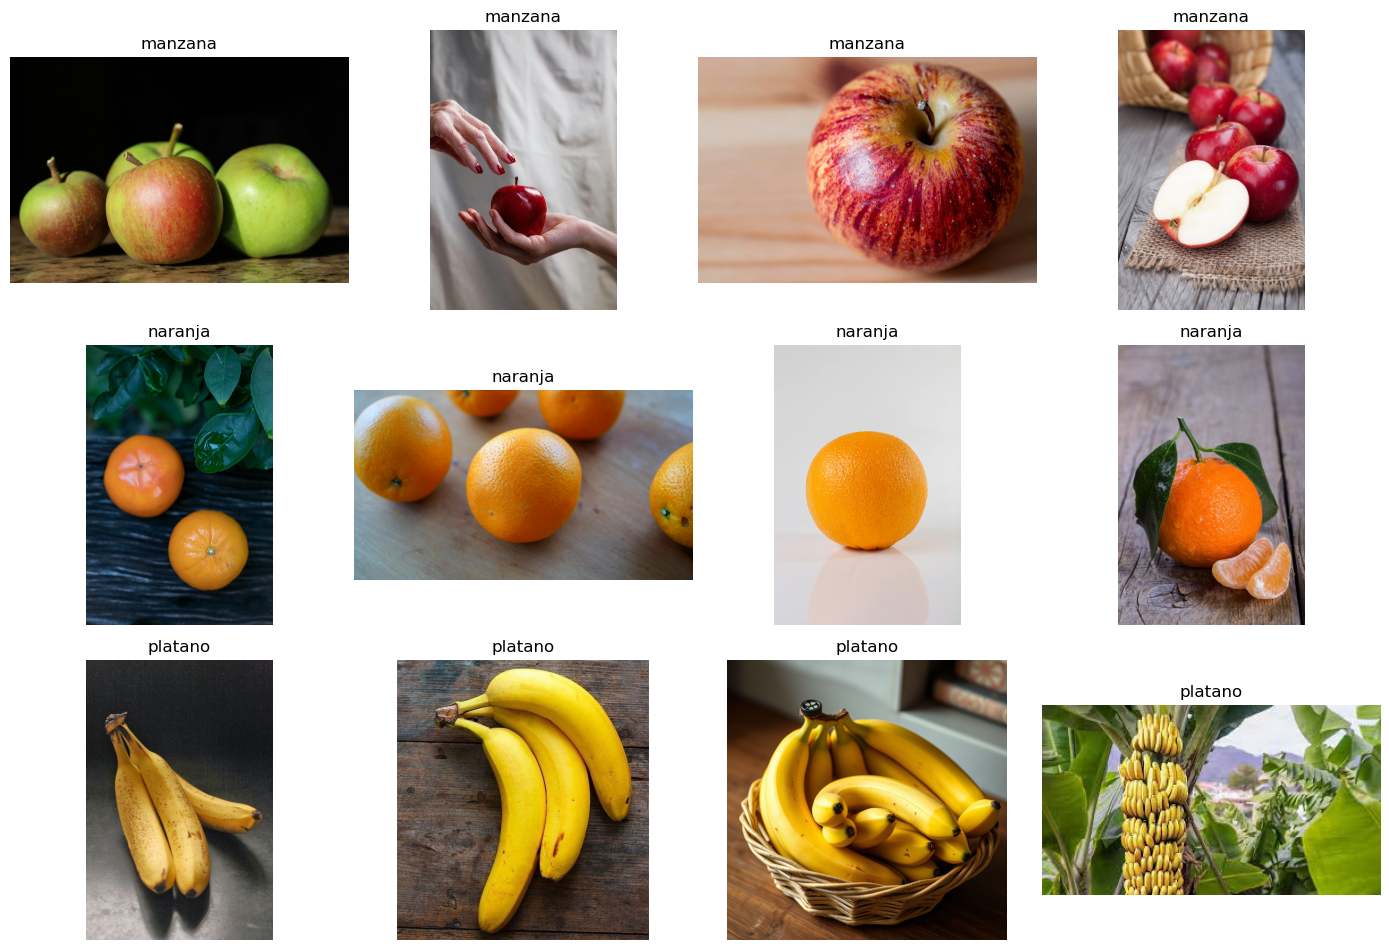

In [6]:
# =========================
# 4) Muestras visuales por clase (montaje)
# =========================
def sample_images(data_dir, classes, n_per_class=3, seed=123):
    random.seed(seed)
    plt.figure(figsize=(3.5*n_per_class, 3.2*len(classes)))
    idx = 1
    for cls in classes:
        imgs = [p for p in (data_dir/cls).rglob("*") if p.suffix.lower() in IMG_EXTS]
        if len(imgs) == 0:
            continue
        pick = random.sample(imgs, min(n_per_class, len(imgs)))
        for p in pick:
            plt.subplot(len(classes), n_per_class, idx)
            img = Image.open(p).convert("RGB")
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            idx += 1
    plt.tight_layout()
    plt.show()

sample_images(DATA_DIR, classes, n_per_class=4)

w                                                           h  \
        count    mean     std    min    25%     50%     75%     max count   
clase                                                                       
manzana  40.0  3265.4  2189.0  576.0  736.0  3149.0  4786.2  8192.0  40.0   
naranja  33.0  2293.5  2130.0  194.0  612.0   768.0  4000.0  8192.0  33.0   
platano  31.0   521.2   191.5  225.0  305.0   563.0   728.0   736.0  31.0   

                                                                
           mean     std    min     25%     50%     75%     max  
clase                                                           
manzana  3147.7  1629.1  736.0  1322.2  3213.0  4020.0  6240.0  
naranja  2858.5  2688.1  170.0   563.0  1288.0  5269.0  8192.0  
platano   642.2   423.8  161.0   183.0   611.0  1065.5  1308.0

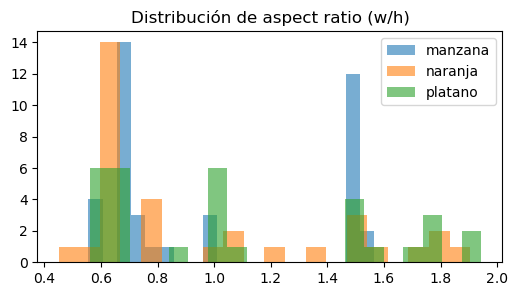

In [8]:
# =========================
# 5) Revisión rápida de tamaños (ancho/alto) por clase
# =========================
def collect_sizes_per_class(max_per_class=80, seed=123):
    rng = np.random.default_rng(seed)
    out = []
    for cls in classes:
        imgs = [p for p in (DATA_DIR/cls).rglob("*") if p.suffix.lower() in IMG_EXTS]
        if len(imgs) == 0:
            continue
        rng.shuffle(imgs)
        for p in imgs[:max_per_class]:
            im = Image.open(p).convert("RGB")
            w, h = im.size
            out.append({"clase": cls, "w": w, "h": h, "path": str(p)})
    return pd.DataFrame(out)

df_sizes = collect_sizes_per_class()
display(df_sizes.groupby("clase")[["w","h"]].describe().round(1))

plt.figure(figsize=(6,3))
for cls in classes:
    sub = df_sizes[df_sizes["clase"]==cls]
    plt.hist((sub["w"]/sub["h"]).values, bins=20, alpha=0.6, label=cls)
plt.title("Distribución de aspect ratio (w/h)")
plt.legend()
plt.show()

In [9]:
# =========================
# 6) Chequeo de imágenes corruptas (rápido)
# =========================
bad = []
for cls in classes:
    for p in (DATA_DIR/cls).rglob("*"):
        if p.suffix.lower() not in IMG_EXTS:
            continue
        try:
            Image.open(p).verify()
        except Exception:
            bad.append(str(p))

print(" Imágenes corruptas:", len(bad))
if bad:
    print("Ejemplos:")
    for b in bad[:10]:
        print(" -", b)

 Imágenes corruptas: 0


In [10]:
# =========================
# 7) Exportar índice del dataset (para Notebook 02)
# =========================
index_rows = []
for cls in classes:
    for p in (DATA_DIR/cls).rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            index_rows.append({"path": str(p), "label": cls})

df_index = pd.DataFrame(index_rows)
out_csv = Path("Proyecto/dataset_index.csv")
df_index.to_csv(out_csv, index=False, encoding="utf-8")
print(" Guardado:", out_csv, "| filas:", len(df_index))
display(df_index.head())

 Guardado: Proyecto\dataset_index.csv | filas: 104


,path,label
0,dataset_fruits\manzana\manzana0.jpg,manzana
1,dataset_fruits\manzana\manzana1.jpg,manzana
2,dataset_fruits\manzana\manzana10.jpg,manzana
3,dataset_fruits\manzana\manzana11.jpg,manzana
4,dataset_fruits\manzana\manzana12.jpg,manzana


In [11]:
# =========================
# 8) Guardar resumen EDA (para reportes)
# =========================
summary = {
    "data_dir": str(DATA_DIR),
    "classes": classes,
    "counts": {row["clase"]: int(row["n_imagenes"]) for row in df_counts.to_dict(orient="records")},
    "total_images": int(total),
    "n_corrupt_images": int(len(bad)),
    "img_size_sample_n": int(len(df_sizes)),
}

out_json = Path("Proyecto/reports/eda_summary.json")
out_json.write_text(json.dumps(summary, indent=2), encoding="utf-8")
print(" Resumen EDA guardado en:", out_json)

 Resumen EDA guardado en: Proyecto\reports\eda_summary.json
